## Introduction
### Resources used
* For loading dataset in kaggle: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463
* For exploring data and training the model, the code was adapted from this notebook: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

## Loading dataset from Kaggle

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision.image import *

In [0]:
!pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
import getpass
print("Paste the content from kaggle.json, then press Enter:")
tokenString = getpass.getpass()
with open('/content/.kaggle/kaggle.json', 'w') as file:
  file.write(tokenString)

Paste the content from kaggle.json, then press Enter:
··········


In [0]:
!mkdir /root/.kaggle/

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p /content/skin-cancer-data

100% 324M/325M [00:09<00:00, 43.3MB/s]
100% 325M/325M [00:09<00:00, 34.6MB/s]


In [0]:
!cd skin-cancer-data; unzip *.zip

Archive:  skin-cancer-malignant-vs-benign.zip
  inflating: data/test/benign/1.jpg  
  inflating: data/test/benign/10.jpg  
  inflating: data/test/benign/1003.jpg  
  inflating: data/test/benign/1006.jpg  
  inflating: data/test/benign/1013.jpg  
  inflating: data/test/benign/1018.jpg  
  inflating: data/test/benign/1019.jpg  
  inflating: data/test/benign/1023.jpg  
  inflating: data/test/benign/1025.jpg  
  inflating: data/test/benign/1029.jpg  
  inflating: data/test/benign/1033.jpg  
  inflating: data/test/benign/1034.jpg  
  inflating: data/test/benign/1042.jpg  
  inflating: data/test/benign/1044.jpg  
  inflating: data/test/benign/105.jpg  
  inflating: data/test/benign/1055.jpg  
  inflating: data/test/benign/1061.jpg  
  inflating: data/test/benign/1070.jpg  
  inflating: data/test/benign/1074.jpg  
  inflating: data/test/benign/1077.jpg  
  inflating: data/test/benign/1080.jpg  
  inflating: data/test/benign/1087.jpg  
  inflating: data/test/benign/1088.jpg  
  inflating: data

## Data augmentation

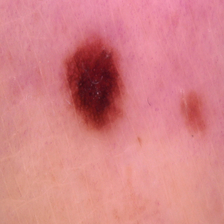

In [0]:
im=open_image('/content/skin-cancer-data/data/train/benign/637.jpg')
im

In [0]:
tfms = get_transforms(max_rotate=180)
def get_ex(): return im

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

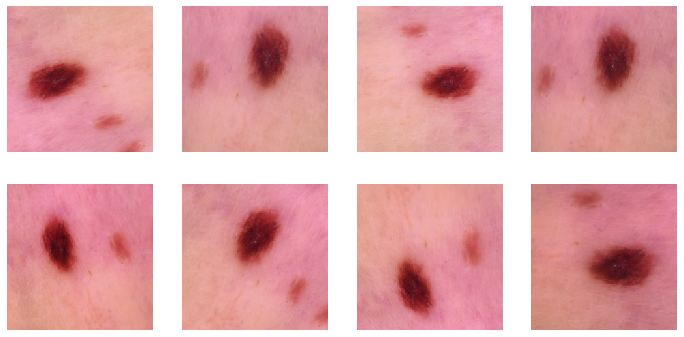

In [0]:
plots_f(2, 4, 12, 6, size=224)

## Defining the DataBunch object

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
!ls -l /content/skin-cancer-data/data/test/benign | wc -l;
!ls -l /content/skin-cancer-data/data/test/malignant | wc -l;
!ls -l /content/skin-cancer-data/data/train/benign | wc -l;
!ls -l /content/skin-cancer-data/data/train/malignant | wc -l;

361
301
1441
1198


In [0]:
!ls -l /content/skin-cancer-data/test/benign | wc -l;
!ls -l /content/skin-cancer-data/test/malignant | wc -l;
!ls -l /content/skin-cancer-data/train/benign | wc -l;
!ls -l /content/skin-cancer-data/train/malignant | wc -l;

361
301
1441
1198


In [0]:
!ls /content/skin-cancer-data

data  skin-cancer-malignant-vs-benign.zip  test  train


In [0]:
!rm -r /content/skin-cancer-data/data;

In [0]:
!rm -r /content/skin-cancer-data/skin-cancer-malignant-vs-benign.zip

In [0]:
#data = ImageDataBunch.from_folder("/content/skin-cancer-data", ds_tfms=tfms)
path = Path('/content/skin-cancer-data/train').resolve()
data = (ImageList.from_folder(path)
        .split_by_rand_pct(valid_pct = 0.2)
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize())

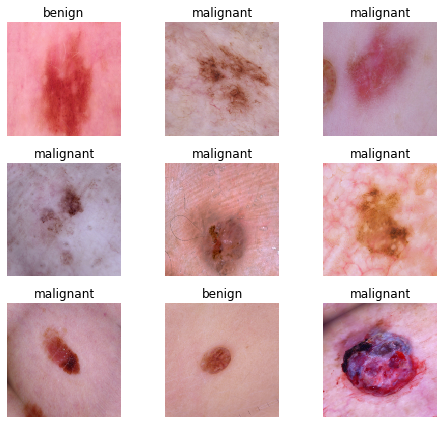

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)

['benign', 'malignant']


In [0]:
data

ImageDataBunch;

Train: LabelList (2110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,malignant,malignant,malignant,malignant
Path: /content/skin-cancer-data/train;

Valid: LabelList (527 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,benign,malignant,malignant,malignant
Path: /content/skin-cancer-data/train;

Test: None

## Training: ResNet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 19.1MB/s]


In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.801677,0.649698,0.172676,00:23
1,0.684317,0.473420,0.197343,00:22
2,0.538100,0.403355,0.168880,00:22
3,0.452720,0.378806,0.159393,00:22


In [0]:
learn.save('stage-1')


## Results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

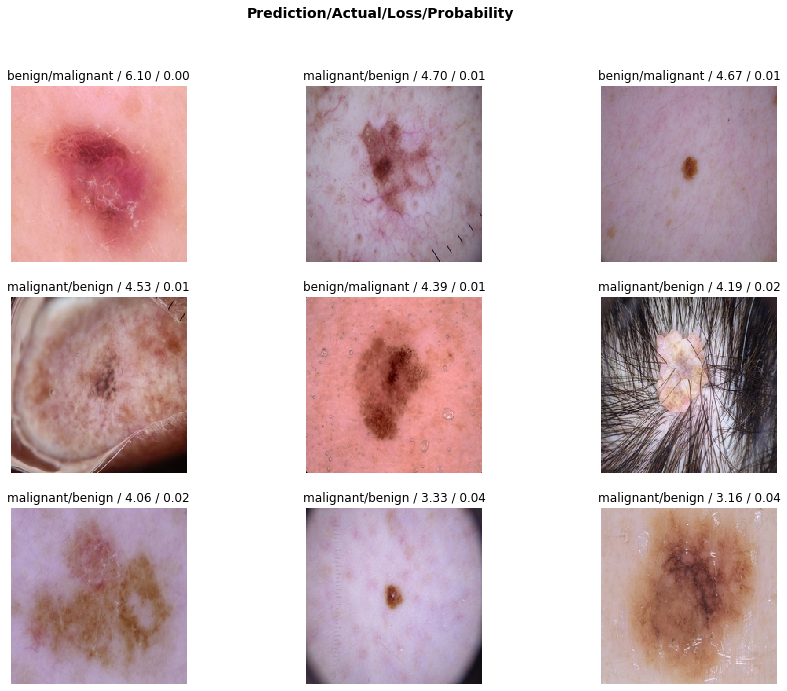

In [0]:
interp.plot_top_losses(9, figsize=(15,11))


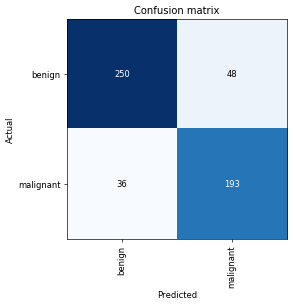

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)


## Unfreezing, fine-tuning, and learning rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


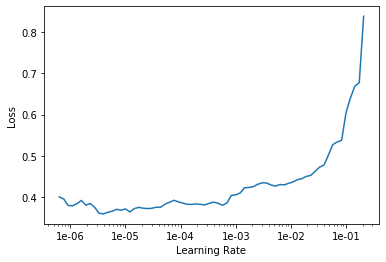

In [0]:
learn.unfreeze()
learn.load('stage-1')
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.360086,0.375805,0.168880,00:24
1,0.359632,0.356676,0.166983,00:24
2,0.359901,0.352178,0.153700,00:24
3,0.345345,0.352391,0.153700,00:23


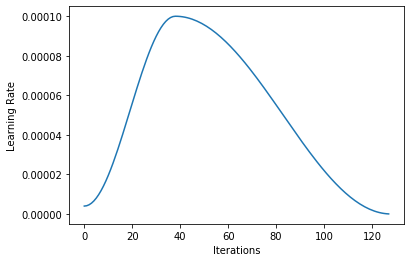

In [0]:
learn.recorder.plot_lr()

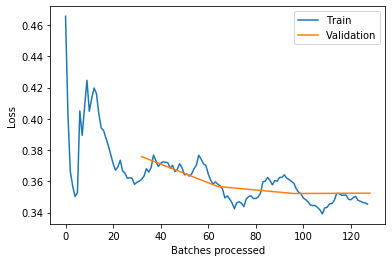

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2');

## Evaluating test error

In [0]:
path = Path('/content/skin-cancer-data').resolve()
data_test = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .databunch()
        .normalize()
       ) 
# Return [loss, error_rate] for test set
learn.validate(data_test.valid_dl)

[0.32474202, tensor(0.1500)]

In [0]:
path = Path('/content/skin-cancer-data').resolve()
data_test = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='train')
        .label_from_folder()
        .databunch()
        .normalize()
       ) 
# Return [loss, error_rate] for train set
learn.validate(data_test.valid_dl)

[0.279148, tensor(0.1187)]